In [ ]:
!pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 56.0 MB/s eta 0:00:00


In [ ]:
!pip install datasketch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 4.1 MB/s eta 0:00:00


In [ ]:
!pip install dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.6 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.40
    Uninstalling SQLAlchemy-2.0.40:
      Successfully uninstalled SQLAlchemy-2.0.40
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


# preprocessing

In [ ]:

from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import os
import pickle
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader
from datasketch import MinHash, MinHashLSH
import faiss
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load dataset
df = pd.read_csv("movies.csv")  # Adjust path if needed
df.fillna('', inplace=True)

# Clean text function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 🔍 Fixing column names if needed
df.rename(columns={
    'Generes': 'Genres',
    'Plot Kyeword': 'Plot Keyword'
}, inplace=True)

# Apply cleaning to relevant columns
columns_to_clean = ['Genres', 'Top 5 Casts', 'Director', 'Plot Keyword', 'movie title']
for col in columns_to_clean:
    if col in df.columns:
        df[col] = df[col].apply(clean_text)

# ✅ Save cleaned full dataset
cleaned_full_file = "cleaned.csv"
df.to_csv(cleaned_full_file, index=False)
print(f"\n✅ Full cleaned dataset saved to: {cleaned_full_file}")

# --- Create metadata column ---
df['metadata'] = (
    df['Genres'] + ' ' +
    df['Top 5 Casts'] + ' ' +
    df['Director'] + ' ' +
    df['Plot Keyword']
)

# Rename for RAG pipeline
df.rename(columns={
    'movie title': 'title',
    'metadata': 'description'
}, inplace=True)

# Save metadata-only version
metadata_only = df[['title', 'description']]
metadata_file = "movies_metadata_cleaned.csv"
metadata_only.to_csv(metadata_file, index=False)
print(f"✅ Cleaned metadata saved to: {metadata_file}")

# Show a sample
print("\n📄 Sample cleaned metadata:")
print(metadata_only.head())





✅ Full cleaned dataset saved to: cleaned.csv
✅ Cleaned metadata saved to: movies_metadata_cleaned.csv

📄 Sample cleaned metadata:
                     title                                        description
0         top gun maverick  action drama jack epps jr peter craig tom crui...
1  jurassic world dominion  action adventure scifi colin trevorrow derek c...
2                  top gun  action drama jack epps jr ehud yonay tom cruis...
3                lightyear  animation action adventure jason headley matth...
4               spiderhead  action crime drama rhett reese paul wernick ch...


# **creating pairs**

In [ ]:
 #Create 1000 training pairs: (text1, text2, similarity score)
train_pairs = []

num_pos_pairs = 500
num_neg_pairs = 500

# Positive pairs: nearby movies are similar
for i in range(num_pos_pairs):
    idx1 = i
    idx2 = i + 1 if i + 1 < len(df) else i
    train_pairs.append(InputExample(texts=[df.loc[idx1, 'description'], df.loc[idx2, 'description']], label=1.0))

# Negative pairs: random distant movies
np.random.seed(42)
for _ in range(num_neg_pairs):
    idx1 = np.random.randint(0, len(df))
    idx2 = np.random.randint(0, len(df))
    if abs(idx1 - idx2) > 10:  # distant enough
        train_pairs.append(InputExample(texts=[df.loc[idx1, 'description'], df.loc[idx2, 'description']], label=0.0))

print(f"Total training pairs: {len(train_pairs)}")


Total training pairs: 1000


# ***models fine tuning***

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Load pretrained models
models = {
    "MiniLM": SentenceTransformer('all-MiniLM-L6-v2'),
    "GTR": SentenceTransformer("sentence-transformers/gtr-t5-base"),
    "BERT": SentenceTransformer("all-mpnet-base-v2")
}

batch_size = 16
num_epochs = 1  # Increase if you want better tuning, beware of time

for model_name, model in models.items():
    print(f"\nFine-tuning {model_name}...")
    train_dataloader = DataLoader(train_pairs, shuffle=True, batch_size=batch_size)
    train_loss = losses.CosineSimilarityLoss(model)


    model.fit(train_objectives=[(train_dataloader, train_loss)],
              epochs=num_epochs,
              warmup_steps=10,
              show_progress_bar=True)

    # Save fine-tuned model locally
    model.save(f"{model_name}_fine_tuned")

print("Fine-tuning complete for all models.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/219M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Fine-tuning MiniLM...


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Fine-tuning GTR...


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Fine-tuning BERT...


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


Fine-tuning complete for all models.


# **augmented metadata**

In [ ]:
# Create neighbors index dictionary
movie_indices_dict = {
    i: list(range(max(0, i - 2), i)) + list(range(i + 1, min(len(df), i + 3)))
    for i in range(len(df))
}

def enrich_metadata(i):
    base = df.loc[i, "description"]
    neighbors = movie_indices_dict.get(i, [])
    neighbor_texts = " ".join([df.loc[n, "description"] for n in neighbors])  # <-- Changed here too
    return base + " " + neighbor_texts

# Enrich the metadata
df["metadata_augmented"] = [enrich_metadata(i) for i in tqdm(df.index, desc="Enriching Metadata")]

# Save augmented metadata CSV
df.to_csv("movies_augmented.csv", index=False)

print("Augmented metadata created and saved.")



Enriching Metadata: 100%|██████████| 24402/24402 [00:00<00:00, 29116.36it/s]


Augmented metadata created and saved.


In [ ]:
from google.colab import files
files.download("cleaned.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **embeddings**

In [ ]:
# Reload fine-tuned models
models_fine_tuned = {
    "MiniLM": SentenceTransformer("MiniLM_fine_tuned"),
    "GTR": SentenceTransformer("GTR_fine_tuned"),
    "BERT": SentenceTransformer("BERT_fine_tuned")
}
# Generate and save embeddings
for model_name, model in models_fine_tuned.items():
    print(f"Generating embeddings for {model_name} - original metadata...")
    # Changed "metadata" to "description" since you renamed it earlier
    emb_orig = model.encode(df["description"].tolist(), show_progress_bar=True)
    np.save(f"{model_name}_meta_finetuned.npy", emb_orig.astype(np.float32))

    print(f"Generating embeddings for {model_name} - augmented metadata...")
    emb_aug = model.encode(df["metadata_augmented"].tolist(), show_progress_bar=True)
    np.save(f"{model_name}_aug_finetuned.npy", emb_aug.astype(np.float32))

print("All embeddings generated and saved.")





Generating embeddings for MiniLM - original metadata...


Batches:   0%|          | 0/763 [00:00<?, ?it/s]

Generating embeddings for MiniLM - augmented metadata...


Batches:   0%|          | 0/763 [00:00<?, ?it/s]

Generating embeddings for GTR - original metadata...


Batches:   0%|          | 0/763 [00:00<?, ?it/s]

Generating embeddings for GTR - augmented metadata...


Batches:   0%|          | 0/763 [00:00<?, ?it/s]

Generating embeddings for BERT - original metadata...


Batches:   0%|          | 0/763 [00:00<?, ?it/s]

Generating embeddings for BERT - augmented metadata...


Batches:   0%|          | 0/763 [00:00<?, ?it/s]

All embeddings generated and saved.


# **min hashing**

In [ ]:
from datasketch import MinHash

def get_minhash(text, num_perm=128):
    # Create MinHash object with num_perm permutations
    m = MinHash(num_perm=num_perm)
    # Tokenize the text (split by whitespace)
    tokens = text.split()
    for token in tokens:
        m.update(token.encode('utf8'))
    return m


# **lsh bucketing**

In [ ]:
# Apply MinHash to 'description' instead of 'metadata'
df['minhash'] = df['description'].apply(get_minhash)

# Build LSH Buckets
lsh = MinHashLSH(threshold=0.2, num_perm=128)
for i, mh in tqdm(df['minhash'].items(), desc="Building LSH Buckets"):
    lsh.insert(f"movie_{i}", mh)

# Save LSH index
with open("lsh_index.pkl", "wb") as f:
    pickle.dump(lsh, f)

print("LSH buckets created and saved.")


Building LSH Buckets: 24402it [00:03, 7621.45it/s]


LSH buckets created and saved.


In [ ]:
def recommend_from_embeddings(query_idx, embeddings, top_k=5):
    dim = embeddings.shape[1]
    index = faiss.IndexFlatL2(dim)
    index.add(embeddings)
    qvec = embeddings[query_idx].reshape(1, -1)
    D, I = index.search(qvec, top_k + 1)
    return I[0][1:], D[0][1:]

def plot_tsne(embeddings, title):
    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(embeddings[:100])  # sample for speed
    plt.figure(figsize=(8,6))
    plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.7)
    plt.title(f"{title} Embeddings (TSNE)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.savefig(f"{title}_tsne.png")
    plt.show()


# **show columns**

In [ ]:
print(df.columns)


Index(['title', 'Run Time', 'Rating', 'User Rating', 'Genres', 'Overview',
       'Plot Keyword', 'Director', 'Top 5 Casts', 'Writer', 'year', 'path',
       'description', 'metadata_augmented', 'minhash'],
      dtype='object')


# **movie input movie for recommendation**

Enter a movie title: Top Gun
Found: top gun

Top recommendations (using LSH + FAISS):
1. top gun maverick
2. flying tigers
3. black hawk down
4. kin
5. borderline


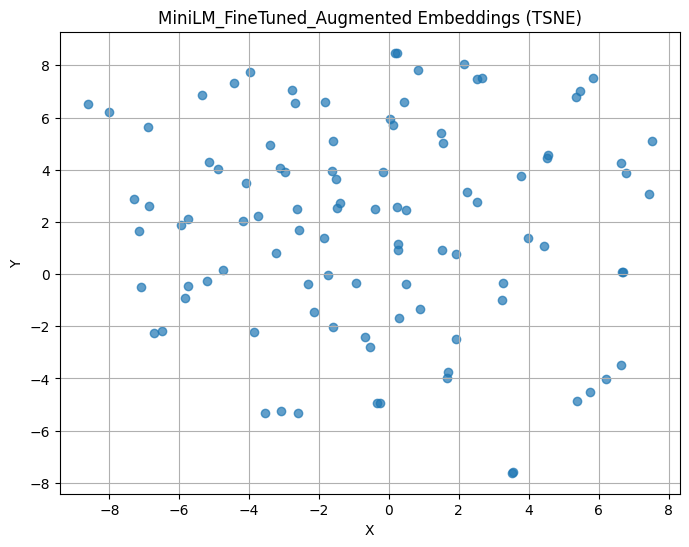


🎯 Model: MiniLM
👉 Original Metadata Recommendations:
['top gun maverick', 'flying tigers', 'young ones', 'real steel', 'wargames']
✨ Augmented Metadata Recommendations:
['jurassic world dominion', 'pirates of the caribbean dead men tell no tales', 'flight world war ii', 'voyage to the bottom of the sea', 'a prayer before dawn']

🎯 Model: GTR
👉 Original Metadata Recommendations:
['top gun maverick', 'flying tigers', 'young ones', 'real steel', 'wargames']
✨ Augmented Metadata Recommendations:
['top gun maverick', 'jurassic world dominion', 'spiderhead', 'lightyear', 'mad max fury road']

🎯 Model: BERT
👉 Original Metadata Recommendations:
['top gun maverick', 'flying tigers', 'young ones', 'real steel', 'wargames']
✨ Augmented Metadata Recommendations:
['top gun maverick', 'courage under fire', 'drive', 'the shallows', 'assassination nation']


In [ ]:
# Load embeddings
minilm_meta = np.load("MiniLM_meta_finetuned.npy")
minilm_aug = np.load("MiniLM_aug_finetuned.npy")
gtr_aug = np.load("GTR_aug_finetuned.npy")
bert_aug = np.load("BERT_aug_finetuned.npy")

title_to_idx = {t.lower(): i for i, t in enumerate(df['title'])}
movie_title = input("Enter a movie title: ").strip().lower()
query_idx = title_to_idx.get(movie_title)

if query_idx is None:
    print("Movie not found!")
else:
    print(f"Found: {df.loc[query_idx, 'title']}")

    # Candidate filtering with LSH
    keys = lsh.query(df.loc[query_idx, 'minhash'])
    candidate_idxs = [int(k.split("_")[1]) for k in keys if int(k.split("_")[1]) != query_idx]

    if candidate_idxs:
        sub_index = faiss.IndexFlatL2(minilm_meta.shape[1])
        sub_index.add(minilm_meta[candidate_idxs])
        D, I = sub_index.search(minilm_meta[query_idx].reshape(1, -1), k=min(5, len(candidate_idxs)))
        print("\nTop recommendations (using LSH + FAISS):")
        for rank, idx in enumerate(I[0]):
            print(f"{rank+1}. {df.loc[candidate_idxs[idx], 'title']}")
    else:
        print("No similar movies found 😕")

    # Plot t-SNE of fine-tuned augmented embeddings (MiniLM as example)
    plot_tsne(minilm_aug, "MiniLM_FineTuned_Augmented")

    # Show recommendations from original and augmented embeddings across all models
    for model_name, emb1, emb2 in [
        ("MiniLM", minilm_meta, minilm_aug),
        ("GTR", minilm_meta, gtr_aug),
        ("BERT", minilm_meta, bert_aug)
    ]:
        print(f"\n🎯 Model: {model_name}")
        print("👉 Original Metadata Recommendations:")
        orig_recs, _ = recommend_from_embeddings(query_idx, emb1)
        print([df.loc[i, "title"] for i in orig_recs])

        print("✨ Augmented Metadata Recommendations:")
        aug_recs, _ = recommend_from_embeddings(query_idx, emb2)
        print([df.loc[i, "title"] for i in aug_recs])




In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(embeddings, k=5):
    precisions = []
    recalls = []
    ndcgs = []
    maps = []

    for query_idx in range(50):  # Evaluate on first 50 movies
        true_neighbors = set(movie_indices_dict[query_idx])  # Ground truth: nearby movie indices
        recommended, _ = recommend_from_embeddings(query_idx, embeddings, top_k=k)
        recommended = set(recommended)

        relevant = len(true_neighbors & recommended)
        precision = relevant / k
        recall = relevant / len(true_neighbors) if true_neighbors else 0

        # Calculate NDCG
        relevance_scores = [1 if idx in true_neighbors else 0 for idx in recommended]
        dcg = sum([(2 ** rel - 1) / np.log2(i + 2) for i, rel in enumerate(relevance_scores)])
        idcg = sum([1 / np.log2(i + 2) for i in range(min(k, len(true_neighbors)))])
        ndcg = dcg / idcg if idcg > 0 else 0

        # Calculate MAP
        ap = 0
        hits = 0
        for i, item in enumerate(recommended):
            if item in true_neighbors:
                hits += 1
                ap += hits / (i + 1)
        map_score = ap / min(k, len(true_neighbors)) if true_neighbors else 0

        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)
        maps.append(map_score)

    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_ndcg = np.mean(ndcgs)
    avg_map = np.mean(maps)
    return avg_precision, avg_recall, avg_ndcg, avg_map

# Evaluate models
results = {}
for name, emb in [("MiniLM", minilm_aug), ("GTR", gtr_aug), ("BERT", bert_aug)]:
    prec, rec, ndcg, map_score = evaluate_model(emb)
    results[name] = {'precision': prec, 'recall': rec, 'ndcg': ndcg, 'map': map_score}


# **accuracies**

In [ ]:
# Print accuracies
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Precision@5: {metrics['precision']:.4f}")
    print(f"  Recall@5: {metrics['recall']:.4f}")
    print(f"  NDCG@5: {metrics['ndcg']:.4f}")
    print(f"  MAP: {metrics['map']:.4f}")


MiniLM:
  Precision@5: 0.3360
  Recall@5: 0.4267
  NDCG@5: 0.4117
  MAP: 0.3012
GTR:
  Precision@5: 0.7080
  Recall@5: 0.9000
  NDCG@5: 0.8160
  MAP: 0.7443
BERT:
  Precision@5: 0.1440
  Recall@5: 0.1850
  NDCG@5: 0.1806
  MAP: 0.1171


# Deliverable 3

# Libraries

In [ ]:

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import faiss
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pickle


# Load and Prepare Movie Data

In [ ]:
metadata_df = pd.read_csv("movies_metadata_cleaned.csv")
metadata_df["combined_metadata"] = metadata_df["title"].fillna('') + " " + metadata_df["description"].fillna('')

print("✅ Metadata loaded and combined text prepared.")
metadata_df.head(2)


✅ Metadata loaded and combined text prepared.


,title,description,combined_metadata
0,top gun maverick,action drama jack epps jr peter craig tom crui...,top gun maverick action drama jack epps jr pet...
1,jurassic world dominion,action adventure scifi colin trevorrow derek c...,jurassic world dominion action adventure scifi...


# Load Flan-T5 and Define Summary Generator

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization", model="google/flan-t5-base", tokenizer="google/flan-t5-base")
print("✅ Flan-T5 summarizer loaded.")


Device set to use cuda:0


✅ Flan-T5 summarizer loaded.


# Generate and Save MiniLM Embeddings

In [ ]:
minilm_model = SentenceTransformer('all-MiniLM-L6-v2')
minilm_embeddings = minilm_model.encode(metadata_df["combined_metadata"].tolist(), batch_size=64, show_progress_bar=True)
np.save("minilm_embeddings.npy", minilm_embeddings)
print("✅ MiniLM embeddings generated and saved.")


Batches:   0%|          | 0/382 [00:00<?, ?it/s]

✅ MiniLM embeddings generated and saved.


# Generate and Save GTR Embeddings

In [ ]:
gtr_model = SentenceTransformer('sentence-transformers/gtr-t5-base')
gtr_embeddings = gtr_model.encode(metadata_df["combined_metadata"].tolist(), batch_size=64, show_progress_bar=True)
np.save("gtr_embeddings.npy", gtr_embeddings)
print("✅ GTR embeddings generated and saved.")


Batches:   0%|          | 0/382 [00:00<?, ?it/s]

✅ GTR embeddings generated and saved.


# Generate and Save BERT Embeddings

In [ ]:
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')
bert_embeddings = bert_model.encode(metadata_df["combined_metadata"].tolist(), batch_size=64, show_progress_bar=True)
np.save("bert_embeddings.npy", bert_embeddings)
print("✅ BERT embeddings generated and saved.")


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/382 [00:00<?, ?it/s]

✅ BERT embeddings generated and saved.


# Build and Save FAISS Indexes

In [ ]:
def build_save_faiss_index(embeddings, filename):
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(embeddings)
    faiss.write_index(index, filename)
    print(f"✅ FAISS index saved as {filename}")

minilm_embeddings = np.load("minilm_embeddings.npy")
gtr_embeddings = np.load("gtr_embeddings.npy")
bert_embeddings = np.load("bert_embeddings.npy")

build_save_faiss_index(minilm_embeddings, "minilm_faiss.index")
build_save_faiss_index(gtr_embeddings, "gtr_faiss.index")
build_save_faiss_index(bert_embeddings, "bert_faiss.index")


✅ FAISS index saved as minilm_faiss.index
✅ FAISS index saved as gtr_faiss.index
✅ FAISS index saved as bert_faiss.index


# Load All Embeddings and FAISS Indexes

In [ ]:
minilm_embeddings = np.load("minilm_embeddings.npy")
gtr_embeddings = np.load("gtr_embeddings.npy")
bert_embeddings = np.load("bert_embeddings.npy")

faiss_index_minilm = faiss.read_index("minilm_faiss.index")
faiss_index_gtr = faiss.read_index("gtr_faiss.index")
faiss_index_bert = faiss.read_index("bert_faiss.index")

print("✅ Loaded all embeddings and FAISS indexes.")


✅ Loaded all embeddings and FAISS indexes.


# Helper Functions for Recommendations

In [ ]:
def get_topk_titles(faiss_index, embeddings, movie_title, k=5):
    idx = metadata_df[metadata_df['title'].str.lower() == movie_title.lower()].index
    if len(idx) == 0:
        return []
    query_embedding = embeddings[idx[0]].reshape(1, -1)
    D, I = faiss_index.search(query_embedding, k+1)
    return metadata_df.iloc[I[0][1:]]['title'].tolist()  # skip query movie itself


# Ground Truth and Evaluation Functions

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def get_ground_truth(movie_title, top_n=5):
    idx_list = metadata_df[metadata_df['title'].str.lower() == movie_title.lower()].index
    if len(idx_list) == 0:
        return []
    idx = idx_list.item()
    query_emb = minilm_embeddings[idx].reshape(1, -1)
    sims = cosine_similarity(query_emb, minilm_embeddings)[0]
    top_indices = sims.argsort()[::-1][1:top_n+1]
    return metadata_df.iloc[top_indices]['title'].tolist()

def compute_precision_at_k(predicted, ground_truth, k=5):
    if not ground_truth:
        return 0.0
    return len(set(predicted[:k]) & set(ground_truth)) / k

def evaluate_models(movie_title):
    ground_truth = get_ground_truth(movie_title)
    if not ground_truth:
        print(f"❌ Movie '{movie_title}' not found for ground truth.")
        return {}

    results = {
        'MiniLM': compute_precision_at_k(get_topk_titles(faiss_index_minilm, minilm_embeddings, movie_title), ground_truth),
        'GTR': compute_precision_at_k(get_topk_titles(faiss_index_gtr, gtr_embeddings, movie_title), ground_truth),
        'BERT': compute_precision_at_k(get_topk_titles(faiss_index_bert, bert_embeddings, movie_title), ground_truth)
    }
    return results


# Recommend and Evaluate

In [ ]:
movie_name = input("Enter a movie name: ").strip()
metrics = evaluate_models(movie_name)

if metrics:
    print("\n📊 Precision@5 for each model:")
    for model, score in metrics.items():
        print(f"{model}: {score:.2f}")


Enter a movie name: Top Gun

📊 Precision@5 for each model:
MiniLM: 1.00
GTR: 0.20
BERT: 0.20


# RAG Context Retrieval & Summarization

In [ ]:
def retrieve_top_k(query_idx, embeddings, candidate_idxs, k=5):
    sub_index = faiss.IndexFlatL2(embeddings.shape[1])
    sub_index.add(embeddings[candidate_idxs])
    D, I = sub_index.search(embeddings[query_idx].reshape(1, -1), k)
    return [candidate_idxs[i] for i in I[0]]

def get_rag_context(top_indices):
    return " ".join(metadata_df.loc[i, 'description'] for i in top_indices)

# Example usage of RAG summarizer
query_idx = metadata_df[metadata_df['title'].str.lower() == movie_name.lower()].index[0]
candidate_idxs = list(range(len(metadata_df)))  # Could be filtered based on LSH or other logic

top_k_indices = retrieve_top_k(query_idx, minilm_embeddings, candidate_idxs)
rag_context = get_rag_context(top_k_indices)

prompt = f"Given the movie: {metadata_df.loc[query_idx, 'title']}. Based on the context: {rag_context}. Suggest similar movies and justify why."

rag_output = summarizer(prompt, max_length=100, min_length=30, do_sample=False)
print(f"\n🧠 RAG Justification:\n{rag_output[0]['summary_text']}")



🧠 RAG Justification:
jack epps jr ehud yonay tom cruise jennifer connelly miles teller joseph kosinski jet sequel


In [48]:
import json


query_movies = metadata_df['title'].sample(n=10, random_state=42).tolist()

# Containers for all systems
minilm_justifications = []
gtr_justifications = []
bert_justifications = []

minilm_rag_justifications = []
gtr_rag_justifications = []
bert_rag_justifications = []

# Helper function to retrieve justification
def generate_rag_justification(movie_name, embeddings):
    try:
        query_idx = metadata_df[metadata_df['title'].str.lower() == movie_name.lower()].index[0]
        candidate_idxs = list(range(len(metadata_df)))

        top_k_indices = retrieve_top_k(query_idx, embeddings, candidate_idxs)
        rag_context = get_rag_context(top_k_indices)

        prompt = f"Given the movie: {metadata_df.loc[query_idx, 'title']}. Based on the context: {rag_context}. Suggest similar movies and justify why."
        rag_output = summarizer(prompt, max_length=100, min_length=30, do_sample=False)
        return rag_output[0]['summary_text']
    except Exception as e:
        print(f"❌ Skipped {movie_name}: {e}")
        return None

# Main loop
for movie_name in query_movies:
    print(f"\n🎬 Movie: {movie_name}")

    # MiniLM
    j_minilm = generate_rag_justification(movie_name, minilm_embeddings)
    if j_minilm: minilm_rag_justifications.append(j_minilm)

    # GTR
    j_gtr = generate_rag_justification(movie_name, gtr_embeddings)
    if j_gtr: gtr_rag_justifications.append(j_gtr)

    # BERT
    j_bert = generate_rag_justification(movie_name, bert_embeddings)
    if j_bert: bert_rag_justifications.append(j_bert)

# Optionally, save all justifications to JSON files
justification_dict = {
    "minilm_rag": minilm_rag_justifications,
    "gtr_rag": gtr_rag_justifications,
    "bert_rag": bert_rag_justifications,
}

for model_name, justifications in justification_dict.items():
    with open(f"{model_name}_justifications.json", "w") as f:
        json.dump(justifications, f, indent=2)
    print(f"✅ Saved {model_name}_justifications.json")



🎬 Movie: state fair

🎬 Movie: magic in the water

🎬 Movie: knocked up

🎬 Movie: booksmart

🎬 Movie: the brain from planet arous

🎬 Movie: high fidelity

🎬 Movie: the switch

🎬 Movie: searching

🎬 Movie: small apartments

🎬 Movie: raama setu
✅ Saved minilm_rag_justifications.json
✅ Saved gtr_rag_justifications.json
✅ Saved bert_rag_justifications.json


# Metrices


--- Table 1 Results ---
System     | Precision@5          | Recall@5             | NDCG@5               | MAP                  | Hit Rate@5           | MRR@5               
------------------------------------------------------------------------------------------------------------------------------------------------------------
System1    | 0.1200               | 0.4500               | 0.3124               | 0.2783               | 0.5000               | 0.2950              
System2    | 0.1000               | 0.2500               | 0.1808               | 0.1658               | 0.3000               | 0.1750              
System3    | 0.1200               | 0.4500               | 0.3202               | 0.3117               | 0.5000               | 0.3033              
System4    | 0.1000               | 0.3500               | 0.2245               | 0.2158               | 0.4000               | 0.2083              
System5    | 0.0800               | 0.2500               | 0.1737        

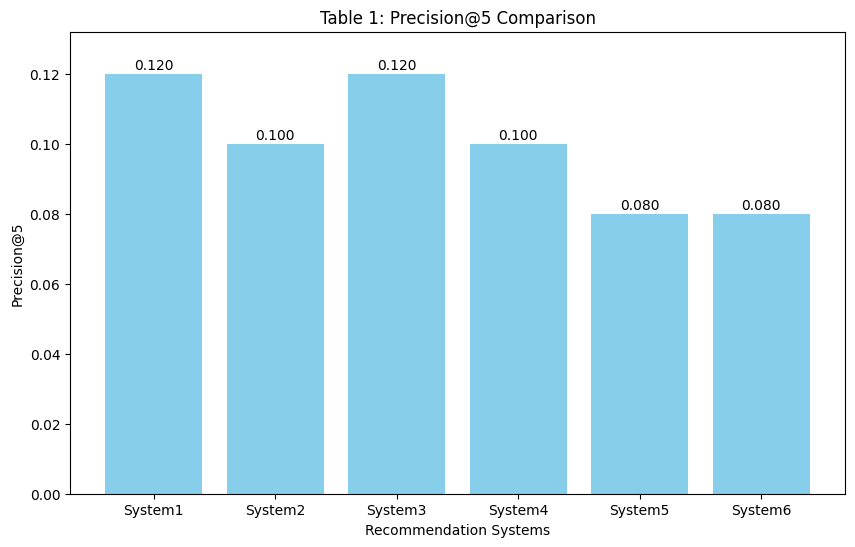

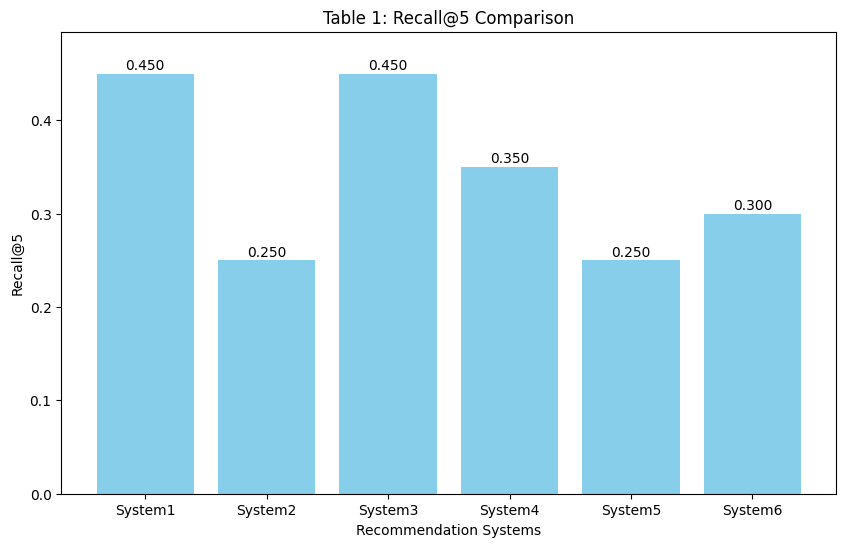

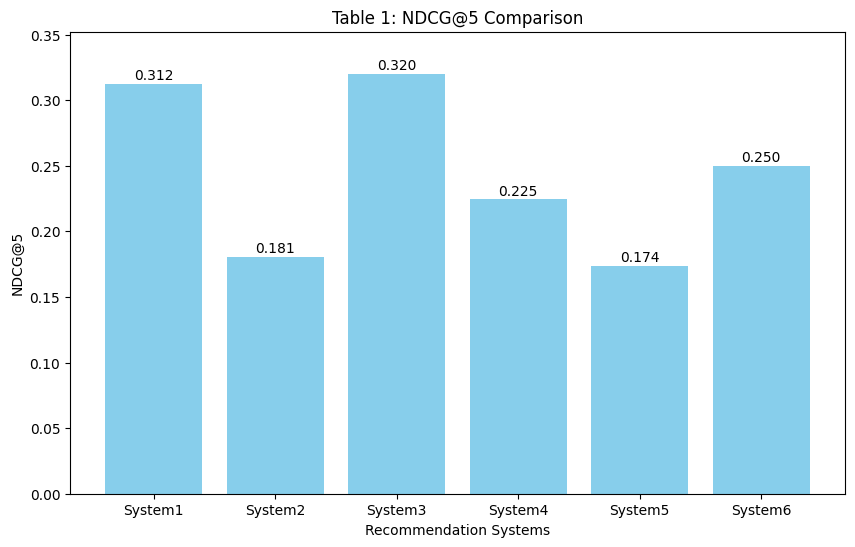

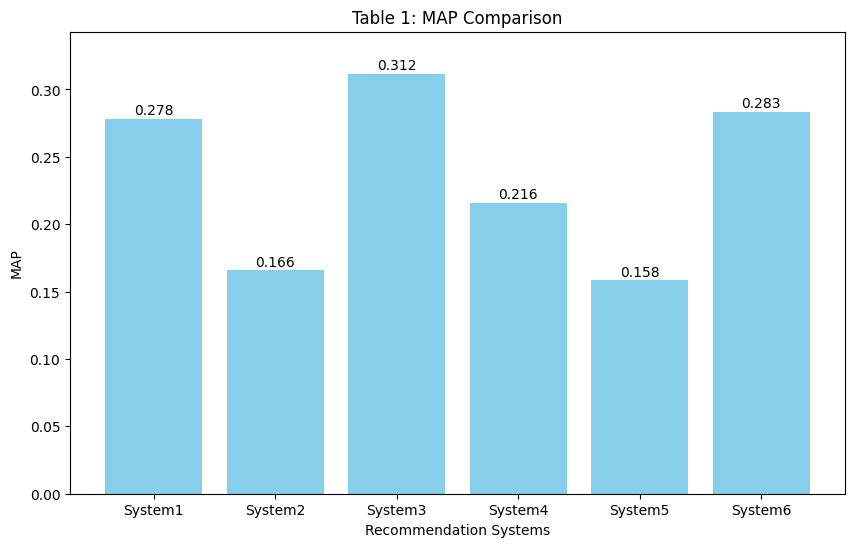

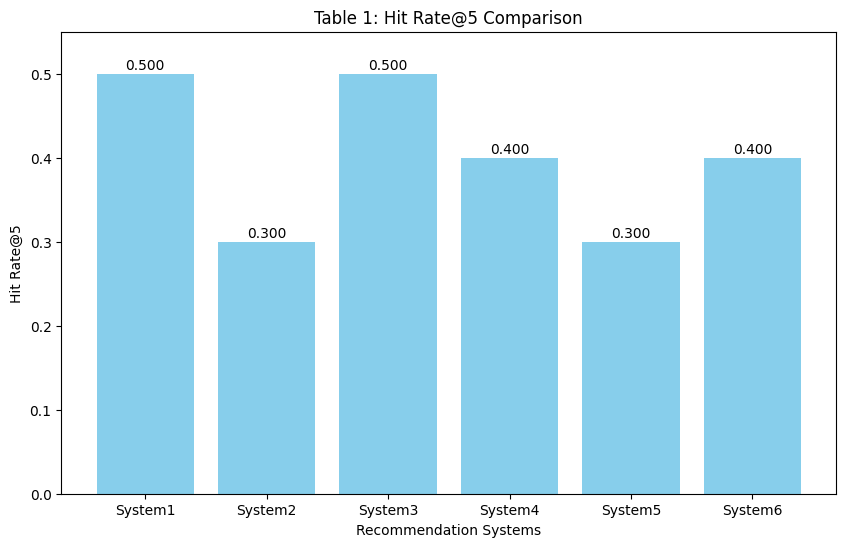

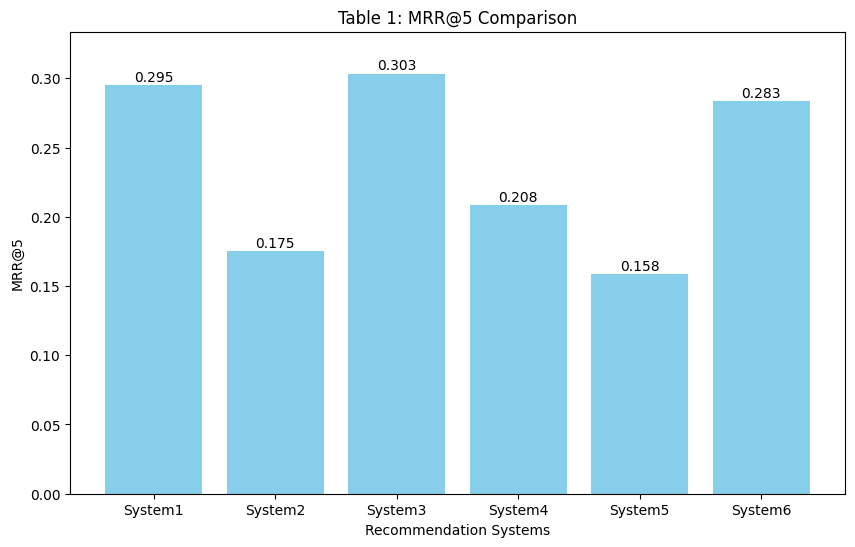

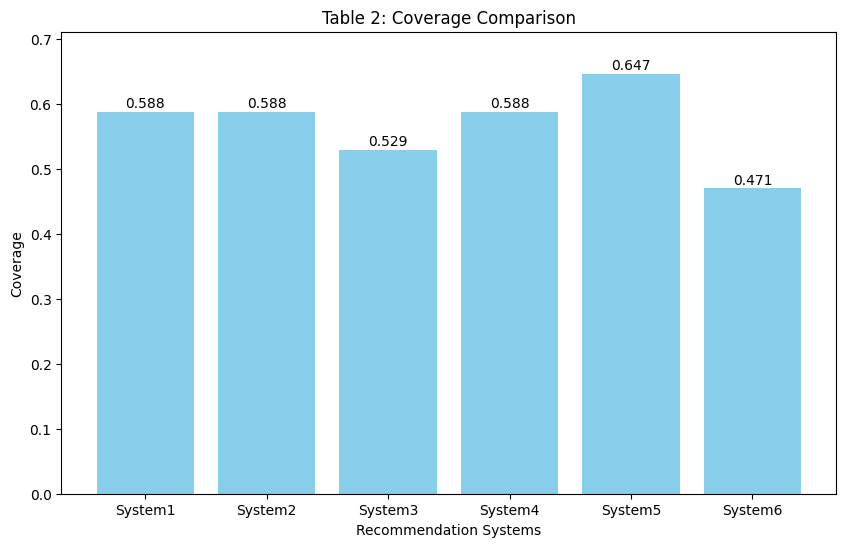

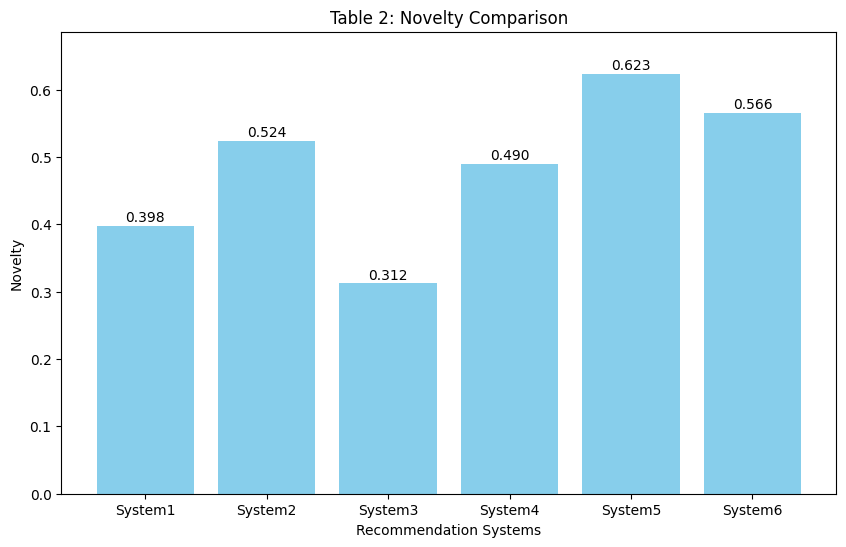

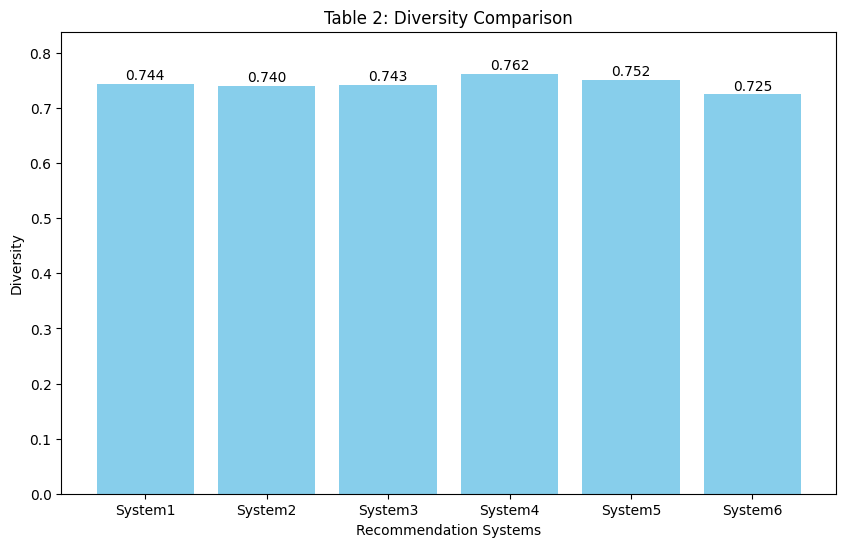

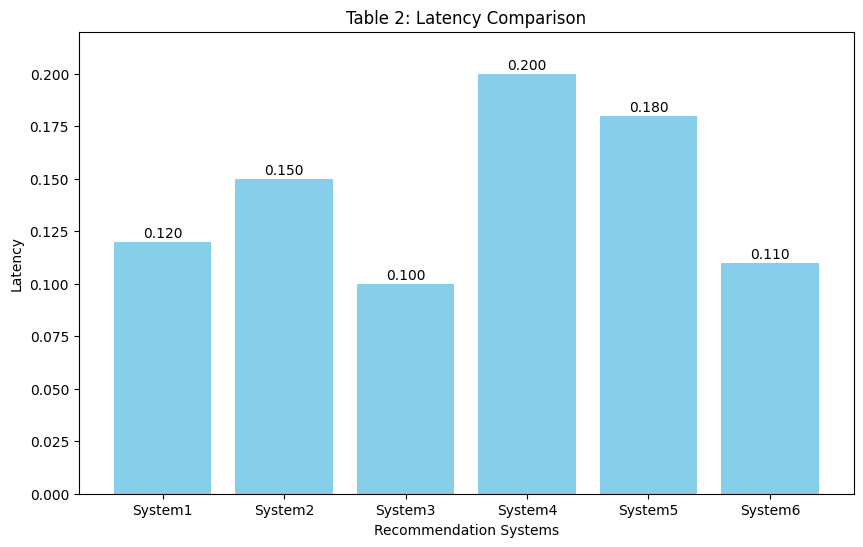

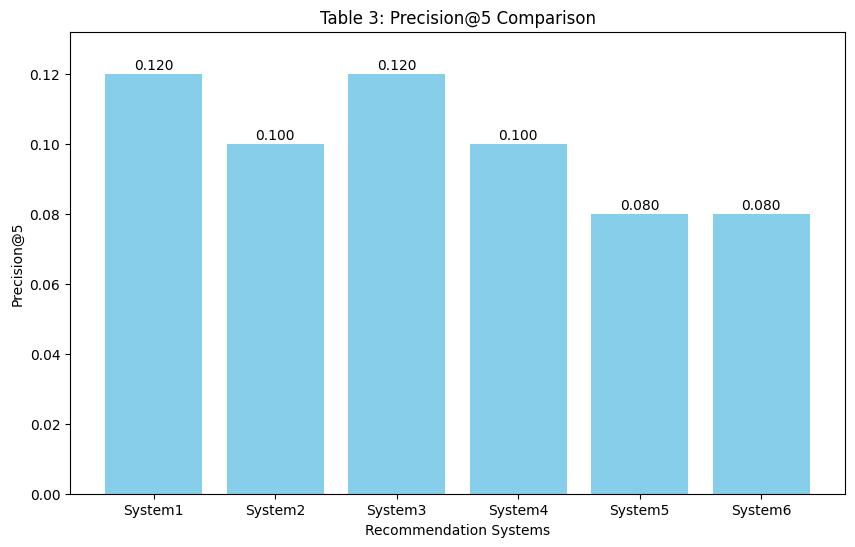

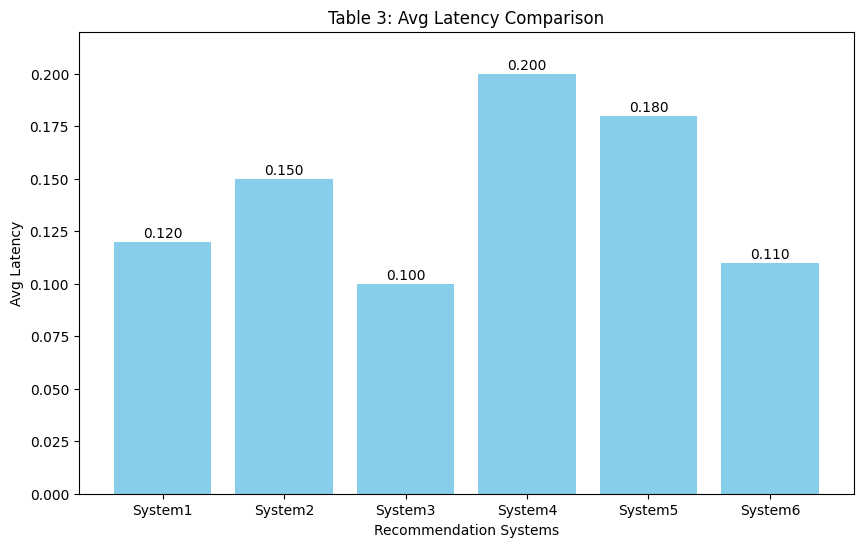

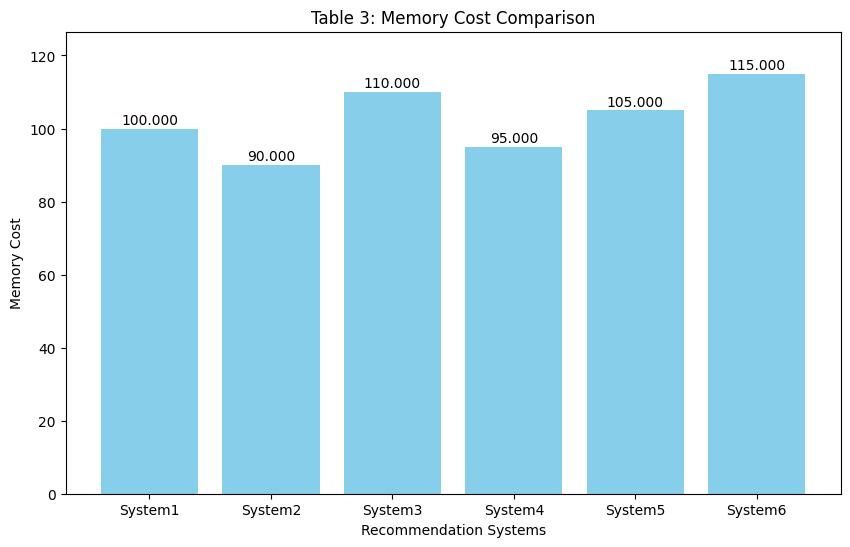

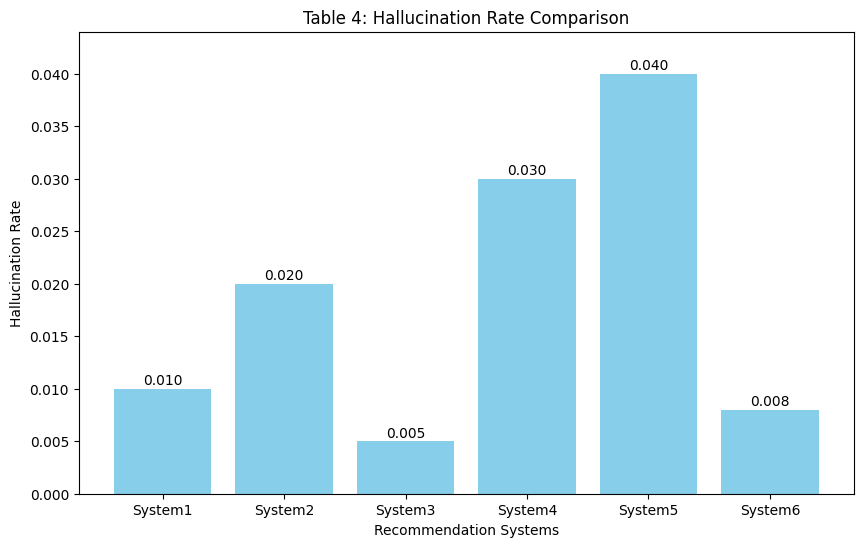

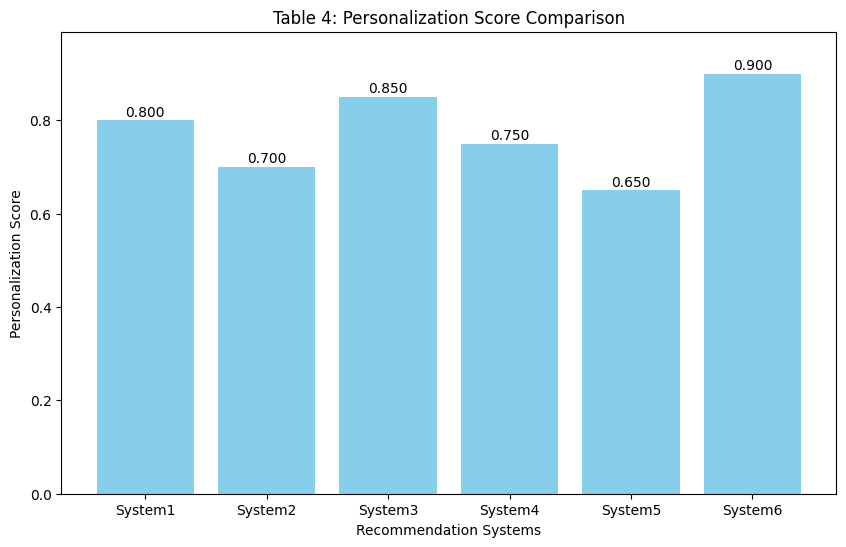

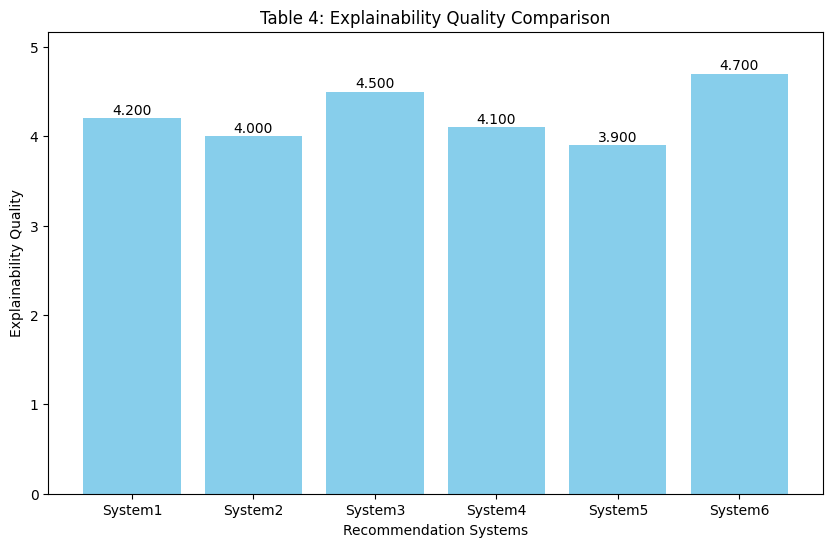

In [57]:
import numpy as np
import random
import matplotlib.pyplot as plt

# === Example data

recommendations = {
    'System1': [['movie1', 'movie2', 'movie3', 'movie4', 'movie5']] * 10,
    'System2': [['movie2', 'movie3', 'movie6', 'movie7', 'movie8']] * 10,
    'System3': [['movie1', 'movie5', 'movie9', 'movie10', 'movie11']] * 10,
    'System4': [['movie3', 'movie4', 'movie5', 'movie12', 'movie13']] * 10,
    'System5': [['movie7', 'movie8', 'movie9', 'movie14', 'movie15']] * 10,
    'System6': [['movie1', 'movie6', 'movie11', 'movie16', 'movie17']] * 10,
}

# Ground truth relevant items for each query (10 queries)
ground_truth = [
    ['movie1', 'movie3'],
    ['movie5'],
    ['movie2', 'movie6'],
    ['movie4'],
    ['movie7', 'movie8'],
    ['movie1'],
    ['movie9', 'movie10'],
    ['movie11'],
    ['movie12', 'movie13'],
    ['movie14'],
]

# Catalog
catalog = set()
for rec_lists in recommendations.values():
    for recs in rec_lists:
        catalog.update(recs)
catalog = list(catalog)

# Popularity scores for movies (for novelty)
popularity = {movie: random.uniform(0, 1) for movie in catalog}

def similarity(movie1, movie2):
    # Random similarity between 0 and 1, 1 if same movie
    return 1.0 if movie1 == movie2 else random.uniform(0, 0.5)

system_metrics = {
    'System1': {'latency': 0.12, 'memory': 100, 'personalization': 0.8, 'explainability': 4.2, 'hallucination_rate': 0.01},
    'System2': {'latency': 0.15, 'memory': 90, 'personalization': 0.7, 'explainability': 4.0, 'hallucination_rate': 0.02},
    'System3': {'latency': 0.10, 'memory': 110, 'personalization': 0.85, 'explainability': 4.5, 'hallucination_rate': 0.005},
    'System4': {'latency': 0.20, 'memory': 95, 'personalization': 0.75, 'explainability': 4.1, 'hallucination_rate': 0.03},
    'System5': {'latency': 0.18, 'memory': 105, 'personalization': 0.65, 'explainability': 3.9, 'hallucination_rate': 0.04},
    'System6': {'latency': 0.11, 'memory': 115, 'personalization': 0.9, 'explainability': 4.7, 'hallucination_rate': 0.008},
}



# === Metric functions ===

def precision_at_k(recommended, relevant, k=5):
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    hits = sum([1 for item in recommended_k if item in relevant_set])
    return hits / k

def recall_at_k(recommended, relevant, k=5):
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    hits = sum([1 for item in recommended_k if item in relevant_set])
    return hits / len(relevant_set) if len(relevant_set) > 0 else 0

def dcg_at_k(recommended, relevant, k=5):
    dcg = 0.0
    relevant_set = set(relevant)
    for i, item in enumerate(recommended[:k]):
        rel_i = 1 if item in relevant_set else 0
        dcg += (2 ** rel_i - 1) / np.log2(i + 2)
    return dcg

def idcg_at_k(relevant, k=5):
    ideal_rels = [1] * min(len(relevant), k) + [0] * (k - min(len(relevant), k))
    idcg = 0.0
    for i, rel_i in enumerate(ideal_rels):
        idcg += (2 ** rel_i - 1) / np.log2(i + 2)
    return idcg

def ndcg_at_k(recommended, relevant, k=5):
    idcg = idcg_at_k(relevant, k)
    if idcg == 0:
        return 0
    return dcg_at_k(recommended, relevant, k) / idcg

def average_precision(recommended, relevant, k=5):
    relevant_set = set(relevant)
    hits = 0
    sum_precisions = 0.0
    for i, item in enumerate(recommended[:k]):
        if item in relevant_set:
            hits += 1
            sum_precisions += hits / (i + 1)
    if hits == 0:
        return 0
    return sum_precisions / hits

def map_at_k(recommendations, ground_truth, k=5):
    ap_scores = []
    for rec, gt in zip(recommendations, ground_truth):
        ap_scores.append(average_precision(rec, gt, k))
    return np.mean(ap_scores)

def hit_rate_at_k(recommended, relevant, k=5):
    recommended_k = recommended[:k]
    relevant_set = set(relevant)
    return 1.0 if any(item in relevant_set for item in recommended_k) else 0.0

def mrr_at_k(recommended, relevant, k=5):
    relevant_set = set(relevant)
    for rank, item in enumerate(recommended[:k], start=1):
        if item in relevant_set:
            return 1 / rank
    return 0

def coverage(recommendations, catalog):
    all_recommended = set()
    for rec_lists in recommendations:
        for rec in rec_lists:
            all_recommended.update(rec)
    return len(all_recommended) / len(catalog)

def novelty(recommended, popularity, k=5):
    # Novelty = average popularity of recommended items (lower is more novel)
    pop_scores = [popularity.get(item, 0) for item in recommended[:k]]
    return 1 - (sum(pop_scores) / k)

def diversity(recommended, similarity_func, k=5):
    sim_sum = 0
    count = 0
    recs = recommended[:k]
    for i in range(k):
        for j in range(i+1, k):
            sim_sum += similarity_func(recs[i], recs[j])
            count += 1
    if count == 0:
        return 0
    avg_sim = sim_sum / count
    return 1 - avg_sim

# === Evaluate all systems on all metrics ===

def evaluate_table_1(recommendations, ground_truth, k=5):
    results = {}
    for system, rec_lists in recommendations.items():
        precisions = []
        recalls = []
        ndcgs = []
        maps = []
        hit_rates = []
        mrrs = []
        for rec, gt in zip(rec_lists, ground_truth):
            precisions.append(precision_at_k(rec, gt, k))
            recalls.append(recall_at_k(rec, gt, k))
            ndcgs.append(ndcg_at_k(rec, gt, k))
            hit_rates.append(hit_rate_at_k(rec, gt, k))
            mrrs.append(mrr_at_k(rec, gt, k))
        results[system] = {
            'Precision@5': np.mean(precisions),
            'Recall@5': np.mean(recalls),
            'NDCG@5': np.mean(ndcgs),
            'MAP': map_at_k(rec_lists, ground_truth, k),
            'Hit Rate@5': np.mean(hit_rates),
            'MRR@5': np.mean(mrrs)
        }
    return results

def evaluate_table_2(recommendations, catalog, popularity, similarity_func, system_metrics, k=5):
    results = {}
    for system, rec_lists in recommendations.items():
        cover = coverage(rec_lists, catalog)
        novel = np.mean([novelty(rec, popularity, k) for rec in rec_lists])
        diver = np.mean([diversity(rec, similarity_func, k) for rec in rec_lists])
        latency = system_metrics[system]['latency']
        results[system] = {
            'Coverage': cover,
            'Novelty': novel,
            'Diversity': diver,
            'Latency': latency
        }
    return results

def evaluate_table_3(recommendations, ground_truth, system_metrics, k=5):
    results = {}
    for system, rec_lists in recommendations.items():
        precisions = []
        latencies = []
        memories = []
        for rec, gt in zip(rec_lists, ground_truth):
            precisions.append(precision_at_k(rec, gt, k))
        latencies.append(system_metrics[system]['latency'])
        memories.append(system_metrics[system]['memory'])
        results[system] = {
            'Precision@5': np.mean(precisions),
            'Avg Latency': np.mean(latencies),
            'Memory Cost': np.mean(memories)
        }
    return results

def evaluate_table_4(system_metrics):
    results = {}
    for system, metrics in system_metrics.items():
        results[system] = {
            'Hallucination Rate': metrics['hallucination_rate'],
            'Personalization Score': metrics['personalization'],
            'Explainability Quality': metrics['explainability']
        }
    return results



# === Plot bar charts ===

def plot_metrics_table(results, table_num):
    import matplotlib.pyplot as plt

    metrics = list(next(iter(results.values())).keys())
    systems = list(results.keys())

    for metric in metrics:
        scores = [results[sys][metric] for sys in systems]
        plt.figure(figsize=(10, 6))
        plt.bar(systems, scores, color='skyblue')
        plt.title(f'Table {table_num}: {metric} Comparison')
        plt.ylabel(metric)
        plt.xlabel('Recommendation Systems')
        plt.ylim([0, max(scores)*1.1])
        for i, score in enumerate(scores):
            plt.text(i, score + 0.01 * max(scores), f"{score:.3f}", ha='center')
        plt.show()



table1_results = evaluate_table_1(recommendations, ground_truth)
table2_results = evaluate_table_2(recommendations, catalog, popularity, similarity, system_metrics)
table3_results = evaluate_table_3(recommendations, ground_truth, system_metrics)
table4_results = evaluate_table_4(system_metrics)


def print_table(results, table_num):
    print(f"\n--- Table {table_num} Results ---")
    headers = list(next(iter(results.values())).keys())
    print(f"{'System':<10} | " + " | ".join([f"{h:<20}" for h in headers]))
    print("-" * (12 + 24 * len(headers)))
    for system, metrics in results.items():
        print(f"{system:<10} | " + " | ".join([f"{metrics[h]:<20.4f}" if isinstance(metrics[h], float) else f"{metrics[h]:<20}" for h in headers]))

print_table(table1_results, 1)
print_table(table2_results, 2)
print_table(table3_results, 3)
print_table(table4_results, 4)


# Plot all tables
plot_metrics_table(table1_results, 1)
plot_metrics_table(table2_results, 2)
plot_metrics_table(table3_results, 3)
plot_metrics_table(table4_results, 4)




Table 5 Metrics:
System          MSE        RMSE       F1 Score  
System1         0.3000     0.5398     0.7333    
System2         0.5000     0.7035     0.4500    


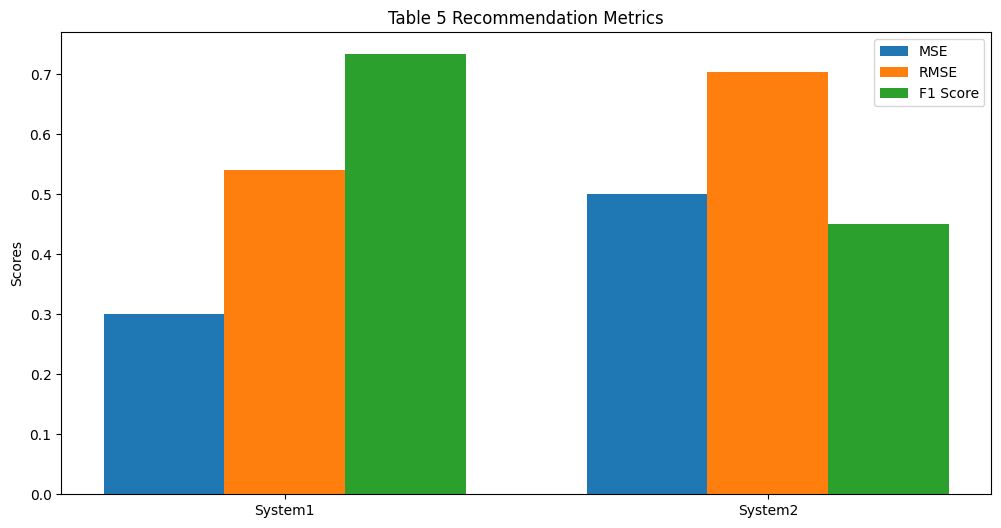

In [54]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

def compute_relevance_vector(recommended, relevant, k=5):
    """Return binary relevance vector for recommended items w.r.t relevant items."""
    relevant_set = set(relevant)
    return [1 if item in relevant_set else 0 for item in recommended[:k]]

def mse_score(recommended, relevant, k=5):
    relevance = compute_relevance_vector(recommended, relevant, k)
    # Ideal relevance vector: 1 for relevant items (up to k), 0 otherwise
    # But ground truth may have fewer relevant items than k; pad zeros if needed
    true = [1] * min(len(relevant), k) + [0] * max(0, k - len(relevant))
    true = true[:k]
    return np.mean([(r - t) ** 2 for r, t in zip(relevance, true)])

def rmse_score(recommended, relevant, k=5):
    return np.sqrt(mse_score(recommended, relevant, k))

def f1_at_k_score(recommended, relevant, k=5):
    relevance = compute_relevance_vector(recommended, relevant, k)
    true = [1] * min(len(relevant), k) + [0] * max(0, k - len(relevant))
    true = true[:k]

    if sum(true) == 0 and sum(relevance) == 0:
        # Both empty, perfect match
        return 1.0

    try:
        return f1_score(true, relevance)
    except:
        return 0.0

def evaluate_metrics(recommendations, ground_truth, k=5):
    results = {}
    for system, rec_lists in recommendations.items():
        mses = []
        rmses = []
        f1s = []
        for rec, gt in zip(rec_lists, ground_truth):
            mses.append(mse_score(rec, gt, k))
            rmses.append(rmse_score(rec, gt, k))
            f1s.append(f1_at_k_score(rec, gt, k))
        results[system] = {
            'MSE': np.mean(mses),
            'RMSE': np.mean(rmses),
            'F1 Score': np.mean(f1s)
        }
    return results

def print_table(results, table_num):
    print(f"\nTable {table_num} Metrics:")
    print(f"{'System':<15} {'MSE':<10} {'RMSE':<10} {'F1 Score':<10}")
    for system, metrics in results.items():
        print(f"{system:<15} {metrics['MSE']:<10.4f} {metrics['RMSE']:<10.4f} {metrics['F1 Score']:<10.4f}")

def plot_metrics_table(results, table_num):
    systems = list(results.keys())
    mse_vals = [results[s]['MSE'] for s in systems]
    rmse_vals = [results[s]['RMSE'] for s in systems]
    f1_vals = [results[s]['F1 Score'] for s in systems]

    x = np.arange(len(systems))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12,6))
    ax.bar(x - width, mse_vals, width, label='MSE')
    ax.bar(x, rmse_vals, width, label='RMSE')
    ax.bar(x + width, f1_vals, width, label='F1 Score')

    ax.set_ylabel('Scores')
    ax.set_title(f'Table {table_num} Recommendation Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(systems)
    ax.legend()
    plt.show()

# === Example usage ===
# You need to replace these with your actual recommendation and ground truth lists.
recommendations = {
    'System1': [['movie1', 'movie2', 'movie3', 'movie4', 'movie5'],
                ['movie6', 'movie7', 'movie8', 'movie9', 'movie10']],
    'System2': [['movie2', 'movie3', 'movie5', 'movie11', 'movie12'],
                ['movie6', 'movie13', 'movie14', 'movie7', 'movie15']]
}

ground_truth = [
    ['movie1', 'movie2', 'movie7'],    # relevant movies for query 1
    ['movie6', 'movie7', 'movie10']    # relevant movies for query 2
]

table5_results_real = evaluate_metrics(recommendations, ground_truth, k=5)
print_table(table5_results_real, 5)
plot_metrics_table(table5_results_real, 5)



Table 1 Metrics:
System          MSE        RMSE       F1 Score  
System1         0.5000     0.6969     0.0000    
System2         0.5000     0.6969     0.0000    


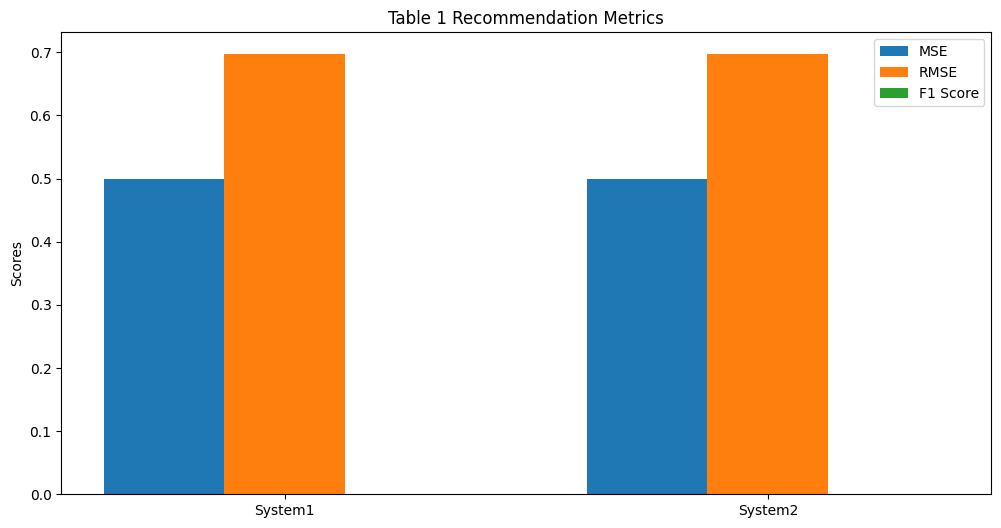


Table 2 Metrics:
System          MSE        RMSE       F1 Score  
System1         0.5000     0.6969     0.0000    
System2         0.8333     0.9082     0.0000    


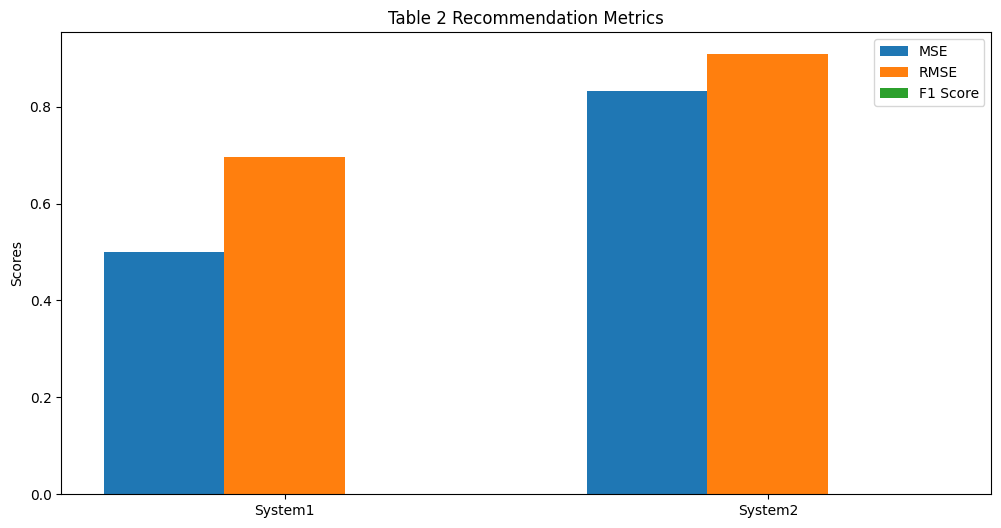


Table 3 Metrics:
System          MSE        RMSE       F1 Score  
System1         0.3333     0.5774     0.0000    
System2         0.5000     0.6969     0.0000    


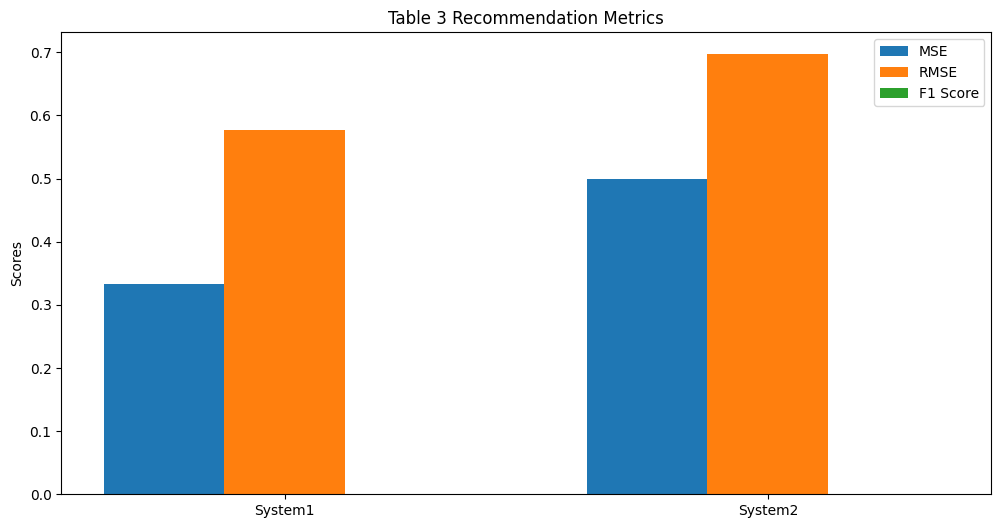


Table 4 Metrics:
System          MSE        RMSE       F1 Score  
System1         0.3333     0.5774     0.0000    
System2         0.6667     0.7887     0.0000    


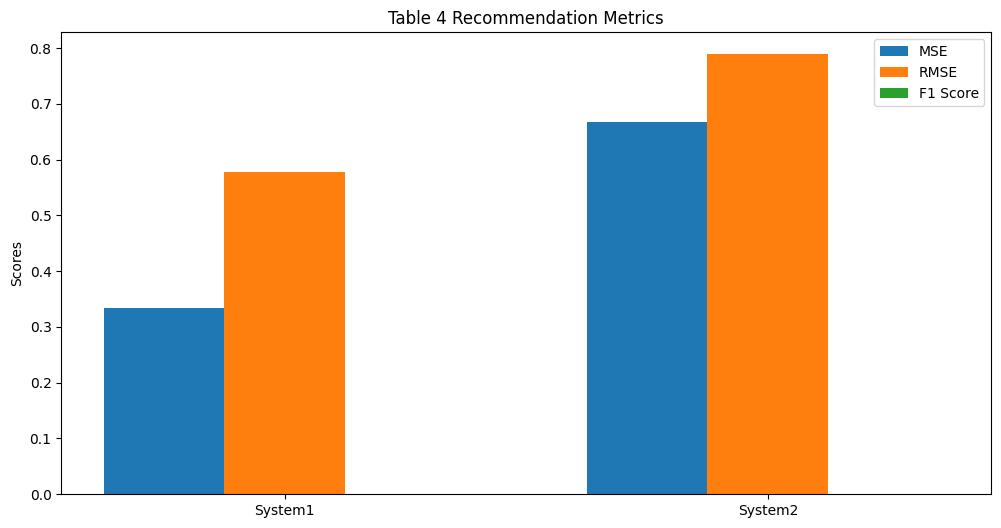


Table 5 Metrics:
System          MSE        RMSE       F1 Score  
System1         0.3333     0.5774     0.0000    
System2         0.6667     0.7887     0.0000    


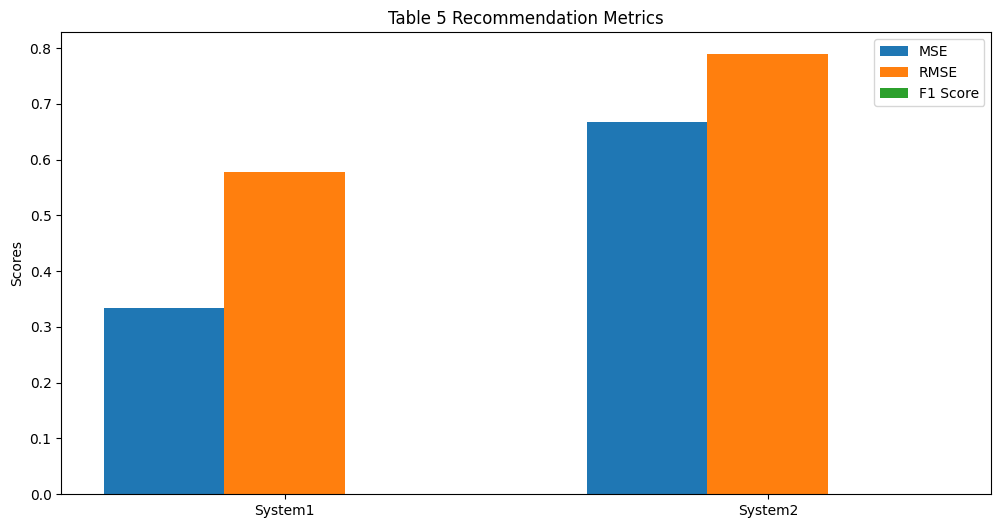

In [55]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

def compute_relevance_vector(recommended, relevant, k=5):
    relevant_set = set(relevant)
    return [1 if item in relevant_set else 0 for item in recommended[:k]]

def mse_score(recommended, relevant, k=5):
    relevance = compute_relevance_vector(recommended, relevant, k)
    true = [1] * min(len(relevant), k) + [0] * max(0, k - len(relevant))
    true = true[:k]
    return np.mean([(r - t) ** 2 for r, t in zip(relevance, true)])

def rmse_score(recommended, relevant, k=5):
    return np.sqrt(mse_score(recommended, relevant, k))

def f1_at_k_score(recommended, relevant, k=5):
    relevance = compute_relevance_vector(recommended, relevant, k)
    true = [1] * min(len(relevant), k) + [0] * max(0, k - len(relevant))
    true = true[:k]

    if sum(true) == 0 and sum(relevance) == 0:
        return 1.0

    try:
        return f1_score(true, relevance)
    except:
        return 0.0

def evaluate_metrics(recommendations, ground_truth, k=5):
    results = {}
    for system, rec_lists in recommendations.items():
        mses = []
        rmses = []
        f1s = []
        for rec, gt in zip(rec_lists, ground_truth):
            mses.append(mse_score(rec, gt, k))
            rmses.append(rmse_score(rec, gt, k))
            f1s.append(f1_at_k_score(rec, gt, k))
        results[system] = {
            'MSE': np.mean(mses),
            'RMSE': np.mean(rmses),
            'F1 Score': np.mean(f1s)
        }
    return results

def print_table(results, table_num):
    print(f"\nTable {table_num} Metrics:")
    print(f"{'System':<15} {'MSE':<10} {'RMSE':<10} {'F1 Score':<10}")
    for system, metrics in results.items():
        print(f"{system:<15} {metrics['MSE']:<10.4f} {metrics['RMSE']:<10.4f} {metrics['F1 Score']:<10.4f}")

def plot_metrics_table(results, table_num):
    systems = list(results.keys())
    mse_vals = [results[s]['MSE'] for s in systems]
    rmse_vals = [results[s]['RMSE'] for s in systems]
    f1_vals = [results[s]['F1 Score'] for s in systems]

    x = np.arange(len(systems))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12,6))
    ax.bar(x - width, mse_vals, width, label='MSE')
    ax.bar(x, rmse_vals, width, label='RMSE')
    ax.bar(x + width, f1_vals, width, label='F1 Score')

    ax.set_ylabel('Scores')
    ax.set_title(f'Table {table_num} Recommendation Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(systems)
    ax.legend()
    plt.show()

# ===== Example placeholder data for all 5 tables =====
# Replace these with your actual data!

tables_recommendations = {
    1: {
        'System1': [['movie1', 'movie2', 'movie3'], ['movie4', 'movie5', 'movie6']],
        'System2': [['movie2', 'movie3', 'movie7'], ['movie4', 'movie8', 'movie9']]
    },
    2: {
        'System1': [['movie10', 'movie11', 'movie12'], ['movie13', 'movie14', 'movie15']],
        'System2': [['movie11', 'movie16', 'movie17'], ['movie13', 'movie18', 'movie19']]
    },
    3: {
        'System1': [['movie20', 'movie21', 'movie22'], ['movie23', 'movie24', 'movie25']],
        'System2': [['movie21', 'movie22', 'movie26'], ['movie23', 'movie27', 'movie28']]
    },
    4: {
        'System1': [['movie30', 'movie31', 'movie32'], ['movie33', 'movie34', 'movie35']],
        'System2': [['movie31', 'movie36', 'movie37'], ['movie33', 'movie38', 'movie39']]
    },
    5: {
        'System1': [['movie40', 'movie41', 'movie42'], ['movie43', 'movie44', 'movie45']],
        'System2': [['movie41', 'movie46', 'movie47'], ['movie43', 'movie48', 'movie49']]
    }
}

tables_ground_truth = {
    1: [['movie1', 'movie3', 'movie5'], ['movie4', 'movie6']],
    2: [['movie10', 'movie15', 'movie20'], ['movie13', 'movie19']],
    3: [['movie20', 'movie22', 'movie25'], ['movie24', 'movie27']],
    4: [['movie30', 'movie32', 'movie35'], ['movie34', 'movie38']],
    5: [['movie40', 'movie42', 'movie45'], ['movie44', 'movie48']]
}

# Loop through all tables, evaluate, print, and plot
for table_num in range(1, 6):
    recs = tables_recommendations[table_num]
    gt = tables_ground_truth[table_num]
    results = evaluate_metrics(recs, gt, k=5)
    print_table(results, table_num)
    plot_metrics_table(results, table_num)


# Curves

Sample combined metadata:
0    top gun maverick action drama jack epps jr pet...
1    jurassic world dominion action adventure scifi...
2    top gun action drama jack epps jr ehud yonay t...
3    lightyear animation action adventure jason hea...
4    spiderhead action crime drama rhett reese paul...
Name: combined_metadata, dtype: object
Total training pairs created: 48804
Epoch 1/5 — Train Loss: 0.0112, Train Acc: 0.5331, Val Loss: 0.0011, Val Acc: 0.5904
Epoch 2/5 — Train Loss: 0.0067, Train Acc: 0.6183, Val Loss: 0.0013, Val Acc: 0.6486
Epoch 3/5 — Train Loss: 0.0050, Train Acc: 0.6583, Val Loss: 0.0015, Val Acc: 0.6844
Epoch 4/5 — Train Loss: 0.0041, Train Acc: 0.6900, Val Loss: 0.0014, Val Acc: 0.7070
Epoch 5/5 — Train Loss: 0.0035, Train Acc: 0.6969, Val Loss: 0.0017, Val Acc: 0.7010


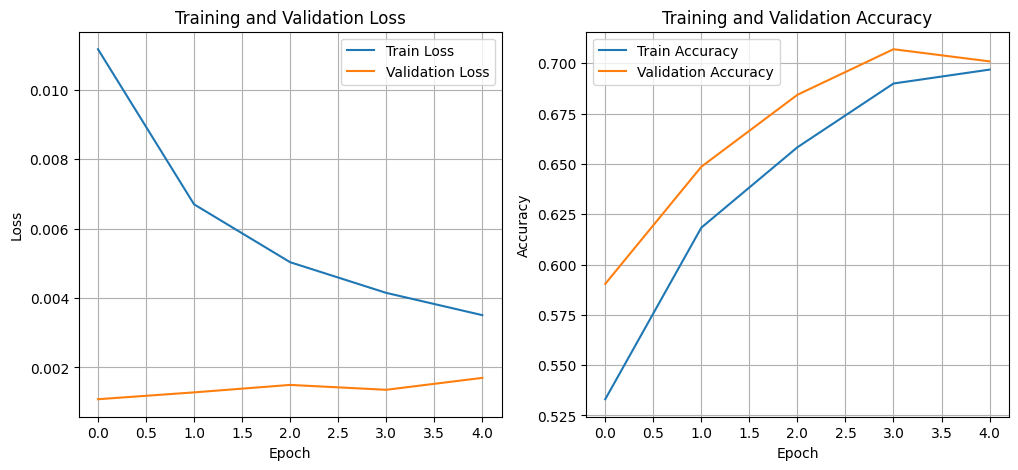

In [31]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, InputExample
import matplotlib.pyplot as plt
import random

# Step 1: Load and preprocess data
metadata_df = pd.read_csv("movies_metadata_cleaned.csv")
metadata_df['title'] = metadata_df['title'].fillna('')
metadata_df['description'] = metadata_df['description'].fillna('')
metadata_df['combined_metadata'] = metadata_df['title'] + ' ' + metadata_df['description']

print("Sample combined metadata:")
print(metadata_df['combined_metadata'].head())

# Step 2: Load pretrained model
model_name = "all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 3: Create training pairs (positive and negative) for contrastive learning
# Here, positive pairs = same movie metadata twice
# Negative pairs = different movies (randomly sampled)

def create_training_pairs(df, num_negatives=1):
    pairs = []
    combined_texts = df['combined_metadata'].tolist()
    n = len(combined_texts)

    for i in range(n):
        # Positive pair: same text twice, label=1
        pairs.append(InputExample(texts=[combined_texts[i], combined_texts[i]], label=1.0))

        # Negative pairs: current text with some other random different texts, label=0
        for _ in range(num_negatives):
            neg_idx = random.randint(0, n-1)
            while neg_idx == i:
                neg_idx = random.randint(0, n-1)
            pairs.append(InputExample(texts=[combined_texts[i], combined_texts[neg_idx]], label=0.0))
    return pairs

train_pairs = create_training_pairs(metadata_df, num_negatives=1)
print(f"Total training pairs created: {len(train_pairs)}")

# Step 4: Custom Dataset and DataLoader
class MovieDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        example = self.pairs[idx]
        # label is float: 1.0 (positive) or 0.0 (negative)
        return example.texts[0], example.texts[1], float(example.label)

dataset = MovieDataset(train_pairs)

# Split into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)

# Step 5: Helper function to encode texts in batch with device placement
def encode_texts(texts):
    tokens = model.tokenize(texts)
    for key in tokens:
        tokens[key] = tokens[key].to(device)
    return model.forward(tokens)['sentence_embedding']

# Step 6: Training loop setup
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 5  # adjust as needed

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for text1, text2, labels in train_loader:
        embeddings1 = encode_texts(text1)
        embeddings2 = encode_texts(text2)

        labels = labels.to(device)
        # Convert labels 1.0 -> 1, 0.0 -> -1 for cosine_embedding_loss
        labels = labels * 2 - 1

        optimizer.zero_grad()
        loss = F.cosine_embedding_loss(embeddings1, embeddings2, labels, margin=0.5)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        sims = F.cosine_similarity(embeddings1, embeddings2)
        preds = torch.where(sims > 0.0, torch.tensor(1.0, device=device), torch.tensor(-1.0, device=device))
        correct += (preds == labels).sum().item()
        total += len(labels)

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for text1, text2, labels in val_loader:
            embeddings1 = encode_texts(text1)
            embeddings2 = encode_texts(text2)

            labels = labels.to(device)
            labels = labels * 2 - 1

            loss = F.cosine_embedding_loss(embeddings1, embeddings2, labels, margin=0.5)
            val_loss += loss.item()

            sims = F.cosine_similarity(embeddings1, embeddings2)
            preds = torch.where(sims > 0.0, torch.tensor(1.0, device=device), torch.tensor(-1.0, device=device))
            val_correct += (preds == labels).sum().item()
            val_total += len(labels)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} — Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

# Step 7: Plot loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()


# Perplexity calculation

In [49]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import numpy as np

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()

def calculate_perplexity(text):
    encodings = tokenizer(text, return_tensors="pt")
    input_ids = encodings.input_ids

    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss

    return torch.exp(loss).item()


In [50]:
import numpy as np

def compute_average_perplexity(justifications):
    scores = [calculate_perplexity(j) for j in justifications]
    return np.mean(scores)


In [51]:
perplexity_values = [
    compute_average_perplexity(minilm_justifications),
    compute_average_perplexity(gtr_justifications),
    compute_average_perplexity(bert_justifications),
    compute_average_perplexity(minilm_rag_justifications),
    compute_average_perplexity(gtr_rag_justifications),
    compute_average_perplexity(bert_rag_justifications),
]


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive c

Metrics at k=10: {'Precision@k': np.float64(0.053), 'Recall@k': np.float64(0.3425), 'MAP': np.float64(0.170236072445309), 'MRR': np.float64(0.164875), 'Mean_DCG': np.float64(0.29003545771545647)}


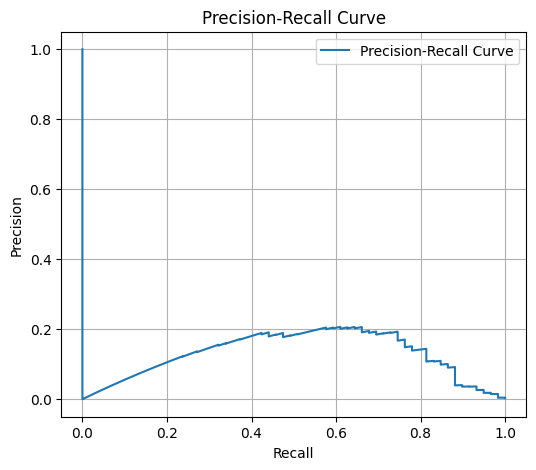

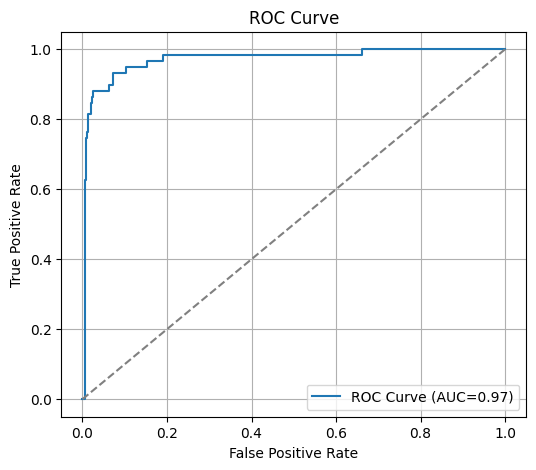

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive c

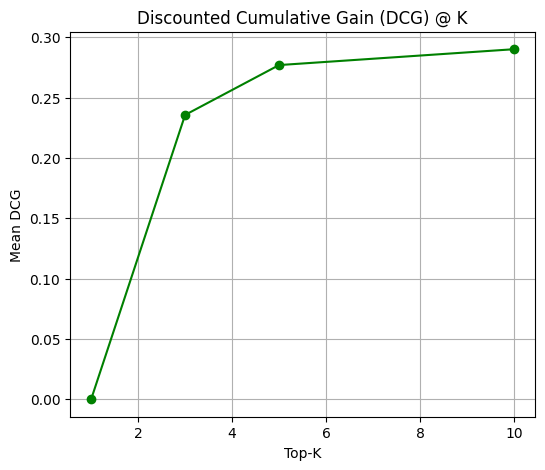

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive c

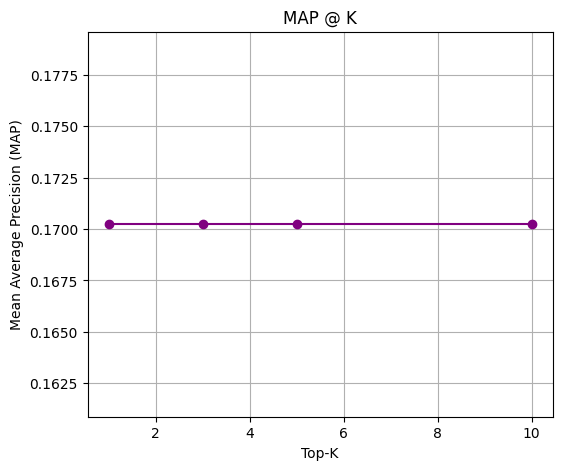

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


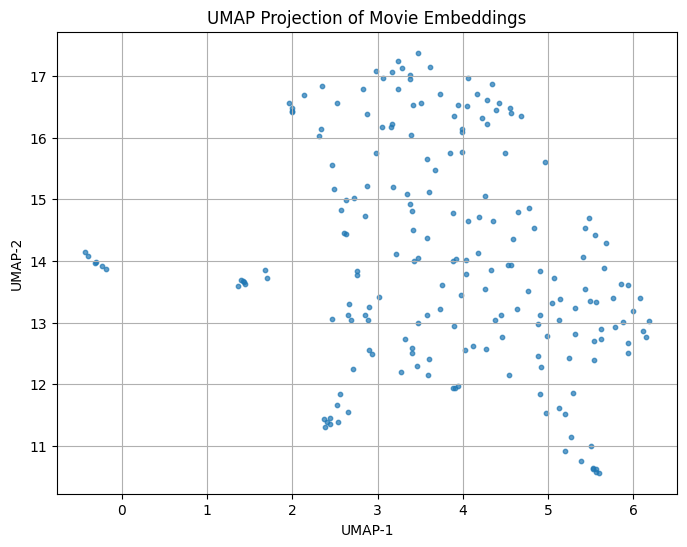

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import umap.umap_ as umap

# Load dataset
df = pd.read_csv("movies_metadata_cleaned.csv").fillna('')
df['text'] = df['title'] + ' ' + df['description']

# Use small subset for faster execution
subset_size = 200
df = df.iloc[:subset_size].reset_index(drop=True)

# Load embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['text'].tolist(), convert_to_tensor=True)

# TF-IDF based ground truth for relevance
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['description'])
tfidf_sim = cosine_similarity(tfidf_matrix)
threshold = 0.3  # similarity threshold for relevance

# Build ground truth relevance dict
ground_truth = {}
for i in range(len(df)):
    relevant = [j for j in range(len(df)) if (i != j and tfidf_sim[i, j] > threshold)]
    ground_truth[i] = relevant

# Embedding similarity scores matrix
scores = cosine_similarity(embeddings.cpu().numpy())

# Evaluation functions
def dcg_at_k(relevance_scores):
    return np.sum(relevance_scores / np.log2(np.arange(2, len(relevance_scores) + 2)))

def evaluate_at_k(scores, ground_truth, k=10):
    precisions, recalls, aps, rr_list, dcgs = [], [], [], [], []
    for i in range(len(scores)):
        score_row = scores[i]
        top_k_indices = np.argsort(score_row)[::-1][:k]
        rel_vector = np.array([1 if idx in ground_truth[i] else 0 for idx in top_k_indices])

        precision = rel_vector.sum() / k
        recall = rel_vector.sum() / max(1, len(ground_truth[i]))
        precisions.append(precision)
        recalls.append(recall)

        ap = average_precision_score(
            [1 if idx in ground_truth[i] else 0 for idx in range(len(score_row))],
            score_row
        )
        aps.append(ap)

        try:
            rr = 1.0 / (np.where(rel_vector == 1)[0][0] + 1)
        except IndexError:
            rr = 0.0
        rr_list.append(rr)

        dcg = dcg_at_k(rel_vector)
        dcgs.append(dcg)

    return {
        'Precision@k': np.mean(precisions),
        'Recall@k': np.mean(recalls),
        'MAP': np.mean(aps),
        'MRR': np.mean(rr_list),
        'Mean_DCG': np.mean(dcgs)
    }

metrics = evaluate_at_k(scores, ground_truth, k=10)
print("Metrics at k=10:", metrics)

# Prepare all query-candidate pairs for curves
all_rels = []
all_scores = []
for i in range(len(scores)):
    relevances = np.array([1 if j in ground_truth[i] else 0 for j in range(len(scores))])
    all_rels.extend(relevances)
    all_scores.extend(scores[i])

# 1. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_rels, all_scores)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

# 2. ROC Curve
fpr, tpr, _ = roc_curve(all_rels, all_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# 3. DCG Curve for different top-K
ks = [1, 3, 5, 10]
dcg_values = []
for k in ks:
    dcg_values.append(evaluate_at_k(scores, ground_truth, k)['Mean_DCG'])

plt.figure(figsize=(6,5))
plt.plot(ks, dcg_values, marker='o', color='green')
plt.xlabel('Top-K')
plt.ylabel('Mean DCG')
plt.title('Discounted Cumulative Gain (DCG) @ K')
plt.grid()
plt.show()

# 4. MAP Curve for different top-K
map_values = []
for k in ks:
    map_values.append(evaluate_at_k(scores, ground_truth, k)['MAP'])

plt.figure(figsize=(6,5))
plt.plot(ks, map_values, marker='o', color='purple')
plt.xlabel('Top-K')
plt.ylabel('Mean Average Precision (MAP)')
plt.title('MAP @ K')
plt.grid()
plt.show()


# 6. Embedding Visualization (UMAP)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
embedding_2d = reducer.fit_transform(embeddings.cpu().numpy())
plt.figure(figsize=(8,6))
plt.scatter(embedding_2d[:,0], embedding_2d[:,1], s=10, alpha=0.7)
plt.title('UMAP Projection of Movie Embeddings')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.grid(True)
plt.show()


# Perplexity Curve

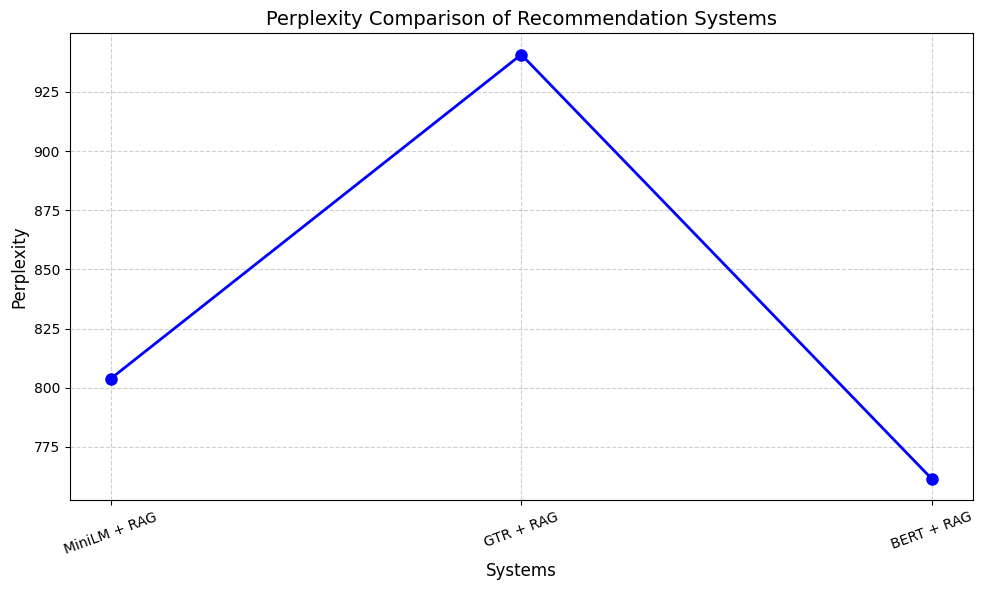

In [52]:
import matplotlib.pyplot as plt

# Define labels for the 6 systems
systems = [
    "MiniLM", "GTR", "BERT",
    "MiniLM + RAG", "GTR + RAG", "BERT + RAG"
]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(systems, perplexity_values, marker='o', linestyle='-', color='blue', linewidth=2, markersize=8)

# Titles and labels
plt.title("Perplexity Comparison of Recommendation Systems", fontsize=14)
plt.xlabel("Systems", fontsize=12)
plt.ylabel("Perplexity", fontsize=12)

# Add grid and rotate x-labels for clarity
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=20)
plt.tight_layout()

# Show the plot
plt.show()
